In [1]:
# !pip install -q torchtoolbox timm

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import os
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
from sklearn import model_selection
import torchvision.transforms as transforms
import torchvision.io 
import librosa
from PIL import Image
import albumentations as alb
import torch.multiprocessing as mp
from pytorch_lightning.callbacks import ModelCheckpoint, BackboneFinetuning, EarlyStopping
import warnings

warnings.filterwarnings('ignore')

In [3]:
import wandb

try:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    api_key = user_secrets.get_secret("wandb_api")
    wandb.login(key=api_key)
    anony = None
except:
    anony = "must"
    print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: 404vector. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [4]:
class Config:
    use_aug = False
    num_classes = 264
    batch_size = 8
    epochs = 12
    PRECISION = 16    
    PATIENCE = 8    
    seed = 2023
    model = "tf_efficientnet_b0_ns"
    pretrained = True            
    weight_decay = 1e-3
    use_mixup = True
    mixup_alpha = 0.2   
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')    
    # default dir : /kaggle/working
    data_root = "../input/birdclef-2023/"
    train_images = "../input/split-creating-melspecs-stage-1/specs/train/"
    valid_images = "../input/split-creating-melspecs-stage-1/specs/valid/"
    train_path = "../input/split-creating-melspecs-stage-1/train.csv"
    valid_path = "../input/split-creating-melspecs-stage-1/valid.csv"
    
    
    SR = 32000
    DURATION = 5
    MAX_READ_SAMPLES = 5
    LR = 5e-4

    wandb_project = "BirdCLEF2023"
    wandb_entity = "birdclef2023_conans"
    

In [5]:
pl.seed_everything(Config.seed, workers=True)

Global seed set to 2023


2023

In [6]:
def config_to_dict(cfg):
    return dict((name, getattr(cfg, name)) for name in dir(cfg) if not name.startswith('__'))

In [7]:
df_train = pd.read_csv(Config.train_path)
df_valid = pd.read_csv(Config.valid_path)
df_train.head()

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename,len_sec_labels,path,frames,sr,duration
0,yebapa1,[],['song'],-3.3923,36.7049,Apalis flavida,Yellow-breasted Apalis,isaac kilusu,Creative Commons Attribution-NonCommercial-Sha...,3.0,https://www.xeno-canto.org/422175,yebapa1/XC422175.ogg,0,/kaggle/input/birdclef-2023/train_audio/yebapa...,405504,32000,12.672000
1,yebapa1,[],['song'],-0.6143,34.0906,Apalis flavida,Yellow-breasted Apalis,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,3.0,https://www.xeno-canto.org/289562,yebapa1/XC289562.ogg,0,/kaggle/input/birdclef-2023/train_audio/yebapa...,796630,32000,24.894687
2,combuz1,[],['call'],51.8585,-8.2699,Buteo buteo,Common Buzzard,Irish Wildlife Sounds,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/626969,combuz1/XC626969.ogg,0,/kaggle/input/birdclef-2023/train_audio/combuz...,254112,32000,7.941000
3,chibat1,['laudov1'],"['adult', 'sex uncertain', 'song']",-33.1465,26.4001,Batis molitor,Chinspot Batis,Lynette Rudman,Creative Commons Attribution-NonCommercial-Sha...,3.5,https://www.xeno-canto.org/664196,chibat1/XC664196.ogg,1,/kaggle/input/birdclef-2023/train_audio/chibat...,1040704,32000,32.522000
4,carcha1,[],['song'],-34.0110,18.8078,Cossypha caffra,Cape Robin-Chat,Shannon Ronaldson,Creative Commons Attribution-NonCommercial-Sha...,1.0,https://www.xeno-canto.org/322333,carcha1/XC322333.ogg,0,/kaggle/input/birdclef-2023/train_audio/carcha...,40124,32000,1.253875


In [8]:
Config.num_classes = len(df_train.primary_label.unique())

In [9]:
df_train = pd.concat([df_train, pd.get_dummies(df_train['primary_label'])], axis=1)
df_valid = pd.concat([df_valid, pd.get_dummies(df_valid['primary_label'])], axis=1)

## Create & Fill birds with 0 samples in validation

In [10]:
birds = list(df_train.primary_label.unique())

In [11]:
missing_birds = list(set(list(df_train.primary_label.unique())).difference(list(df_valid.primary_label.unique())))

In [12]:
non_missing_birds = list(set(list(df_train.primary_label.unique())).difference(missing_birds))

In [13]:
len(non_missing_birds)

254

In [14]:
df_valid[missing_birds] = 0
df_valid = df_valid[df_train.columns] ## Fix order

In [15]:
import albumentations as A
def get_train_transform():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.OneOf([
                A.Cutout(max_h_size=5, max_w_size=16),
                A.CoarseDropout(max_holes=4),
            ], p=0.5),
    ])

In [16]:
class BirdDataset(torch.utils.data.Dataset):

    def __init__(self, df, sr = Config.SR, duration = Config.DURATION, augmentations = None, train = True):

        self.df = df
        self.sr = sr 
        self.train = train
        self.duration = duration
        self.augmentations = augmentations
        if train:
            self.img_dir = Config.train_images
        else:
            self.img_dir = Config.valid_images

    def __len__(self):
        return len(self.df)

    @staticmethod
    def normalize(image):
        image = image / 255.0
        #image = torch.stack([image, image, image])
        return image

    def __getitem__(self, idx):

        row = self.df.iloc[idx]
        impath = self.img_dir + f"{row.filename}.npy"

        image = np.load(str(impath))[:Config.MAX_READ_SAMPLES]
        
        ########## RANDOM SAMPLING ################
        if self.train:
            image = image[np.random.choice(len(image))]
        else:
            image = image[0]
            
        #####################################################################
        
        image = torch.tensor(image).float()

        if self.augmentations:
            image = self.augmentations(image.unsqueeze(0)).squeeze()
            
        image.size()
        
        image = torch.stack([image, image, image])

        image = self.normalize(image)


        return image, torch.tensor(row[17:]).float()


In [17]:
def get_fold_dls(df_train, df_valid):

    ds_train = BirdDataset(
        df_train, 
        sr = Config.SR,
        duration = Config.DURATION,
        augmentations = None,
        train = True
    )
    ds_val = BirdDataset(
        df_valid, 
        sr = Config.SR,
        duration = Config.DURATION,
        augmentations = None,
        train = False
    )
    dl_train = DataLoader(ds_train, batch_size=Config.batch_size , shuffle=True, num_workers = 2)    
    dl_val = DataLoader(ds_val, batch_size=Config.batch_size, num_workers = 2)
    return dl_train, dl_val, ds_train, ds_val

In [18]:
def show_batch(img_ds, num_items, num_rows, num_cols, predict_arr=None):
    fig = plt.figure(figsize=(12, 6))    
    img_index = np.random.randint(0, len(img_ds)-1, num_items)
    for index, img_index in enumerate(img_index):  # list first 9 images
        img, lb = img_ds[img_index]        
        ax = fig.add_subplot(num_rows, num_cols, index + 1, xticks=[], yticks=[])
        if isinstance(img, torch.Tensor):
            img = img.detach().numpy()
        if isinstance(img, np.ndarray):
            img = img.transpose(1, 2, 0)
            ax.imshow(img)        
            
        title = f"Spec"
        ax.set_title(title)  

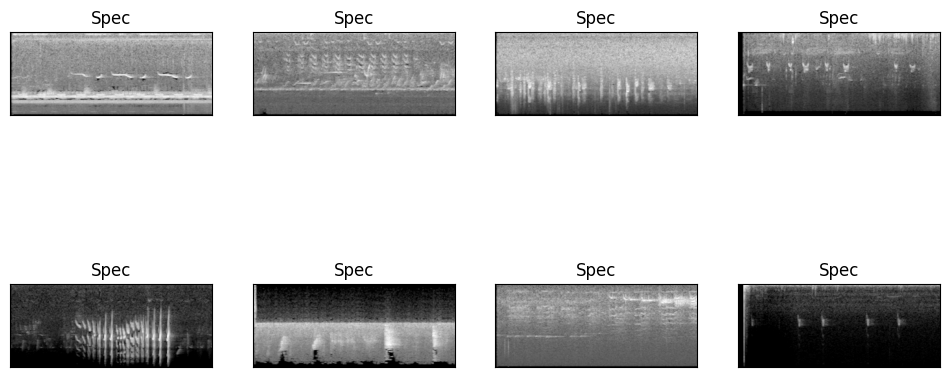

In [19]:
dl_train, dl_val, ds_train, ds_val = get_fold_dls(df_train, df_valid)
show_batch(ds_val, 8, 2, 4)

In [20]:
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts, ReduceLROnPlateau, OneCycleLR

def get_optimizer(lr, params):
    model_optimizer = torch.optim.Adam(
            filter(lambda p: p.requires_grad, params), 
            lr=lr,
            weight_decay=Config.weight_decay
        )
    interval = "epoch"
    
    lr_scheduler = CosineAnnealingWarmRestarts(
                            model_optimizer, 
                            T_0=Config.epochs, 
                            T_mult=1, 
                            eta_min=1e-6, 
                            last_epoch=-1
                        )

    return {
        "optimizer": model_optimizer, 
        "lr_scheduler": {
            "scheduler": lr_scheduler,
            "interval": interval,
            "monitor": "val_loss",
            "frequency": 1
        }
    }

In [21]:
from torchtoolbox.tools import mixup_data, mixup_criterion
import torch.nn as nn
from torch.nn.functional import cross_entropy
import torchmetrics
import timm

In [22]:
import sklearn.metrics

def padded_cmap(solution, submission, padding_factor=5):
    solution = solution#.drop(['row_id'], axis=1, errors='ignore')
    submission = submission#.drop(['row_id'], axis=1, errors='ignore')
    new_rows = []
    for i in range(padding_factor):
        new_rows.append([1 for i in range(len(solution.columns))])
    new_rows = pd.DataFrame(new_rows)
    new_rows.columns = solution.columns
    padded_solution = pd.concat([solution, new_rows]).reset_index(drop=True).copy()
    padded_submission = pd.concat([submission, new_rows]).reset_index(drop=True).copy()
    score = sklearn.metrics.average_precision_score(
        padded_solution.values,
        padded_submission.values,
        average='macro',
    )
    return score

def map_score(solution, submission):
    solution = solution#.drop(['row_id'], axis=1, errors='ignore')
    submission = submission#.drop(['row_id'], axis=1, errors='ignore')
    score = sklearn.metrics.average_precision_score(
        solution.values,
        submission.values,
        average='micro',
    )
    return score

In [23]:
dummy = df_valid[birds].copy()
dummy[birds] = np.random.rand(dummy.shape[0],dummy.shape[1])

In [24]:
padded_cmap(df_valid[birds], dummy[birds], padding_factor = 5)

0.4744901328261848

In [25]:
padded_cmap(df_valid[birds], dummy[birds], padding_factor = 1)

0.21267579101636477

In [26]:
map_score(df_valid[birds], dummy[birds])

0.003721831595762229

In [27]:
class BirdClefModel(pl.LightningModule):
    def __init__(self, model_name=Config.model, num_classes = Config.num_classes, pretrained = Config.pretrained):
        super().__init__()
        self.num_classes = num_classes

        self.backbone = timm.create_model(model_name, pretrained=pretrained)
        self.validation_step_outputs = []

        if 'res' in model_name:
            self.in_features = self.backbone.fc.in_features
            self.backbone.fc = nn.Linear(self.in_features, num_classes)
        elif 'dense' in model_name:
            self.in_features = self.backbone.classifier.in_features
            self.backbone.classifier = nn.Linear(self.in_features, num_classes)
        elif 'efficientnet' in model_name:
            self.in_features = self.backbone.classifier.in_features
            self.backbone.classifier = nn.Sequential(
                nn.Linear(self.in_features, num_classes)
            )
        
        self.loss_function = nn.BCEWithLogitsLoss() 

    def forward(self,images):
        logits = self.backbone(images)
        return logits
        
    def configure_optimizers(self):
        return get_optimizer(lr=Config.LR, params=self.parameters())

    def train_with_mixup(self, X, y):
        X, y_a, y_b, lam = mixup_data(X, y, alpha=Config.mixup_alpha)
        y_pred = self(X)
        loss_mixup = mixup_criterion(cross_entropy, y_pred, y_a, y_b, lam)
        return loss_mixup

    def training_step(self, batch, batch_idx):
        image, target = batch        
        if Config.use_mixup:
            loss = self.train_with_mixup(image, target)
        else:
            y_pred = self(image)
            loss = self.loss_function(y_pred,target)

        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss        

    def validation_step(self, batch, batch_idx):
        image, target = batch     
        y_pred = self(image)
        val_loss = self.loss_function(y_pred, target)
        self.log("val_loss", val_loss, on_step=True, on_epoch=True, logger=True, prog_bar=True)
        output = {"val_loss": val_loss, "logits": y_pred, "targets": target}
        self.validation_step_outputs.append(output)
        return output
    
    def train_dataloader(self):
        return self._train_dataloader 
    
    def validation_dataloader(self):
        return self._validation_dataloader
    
    def on_validation_epoch_end(self):
        outputs = self.validation_step_outputs
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        output_val = torch.cat([x['logits'] for x in outputs],dim=0).sigmoid().cpu().detach().numpy()
        target_val = torch.cat([x['targets'] for x in outputs],dim=0).cpu().detach().numpy()
        
        # print(output_val.shape)
        val_df = pd.DataFrame(target_val, columns = birds)
        pred_df = pd.DataFrame(output_val, columns = birds)
        
        avg_score = padded_cmap(val_df, pred_df, padding_factor = 5)
        avg_score2 = padded_cmap(val_df, pred_df, padding_factor = 3)
        avg_score3 = sklearn.metrics.label_ranking_average_precision_score(target_val,output_val)
        
#         competition_metrics(output_val,target_val)
        print(f'epoch {self.current_epoch} validation loss {avg_loss}')
        print(f'epoch {self.current_epoch} validation C-MAP score pad 5 {avg_score}')
        print(f'epoch {self.current_epoch} validation C-MAP score pad 3 {avg_score2}')
        print(f'epoch {self.current_epoch} validation AP score {avg_score3}')
        
        
        val_df.to_pickle('val_df.pkl')
        pred_df.to_pickle('pred_df.pkl')
        
        
        return {'val_loss': avg_loss,'val_cmap':avg_score}
    
    
    
    

In [28]:
from pytorch_lightning.loggers import WandbLogger
import gc

def run_training():
    print(f"Running training...")
    logger = WandbLogger(project=Config.wandb_project, name=Config.model, entity=Config.wandb_entity, job_type='train')
    
    
    dl_train, dl_val, ds_train, ds_val = get_fold_dls(df_train, df_valid)
    
    audio_model = BirdClefModel()

    early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.00, patience=Config.PATIENCE, verbose= True, mode="min")
    checkpoint_callback = ModelCheckpoint(monitor='val_loss',
                                          dirpath= "/kaggle/working/exp1/",
                                      save_top_k=1,
                                      save_last= True,
                                      save_weights_only=True,
                                      filename= f'./{Config.model}_loss',
                                      verbose= True,
                                      mode='min')
    
    callbacks_to_use = [checkpoint_callback,early_stop_callback]


    trainer = pl.Trainer(
        # gpus=1,
        val_check_interval=0.5,
        deterministic=True,
        max_epochs=Config.epochs,
        logger=logger,
        # auto_lr_find=False,    
        callbacks=callbacks_to_use,
        precision=Config.PRECISION, accelerator="gpu" 
    )

    print("Running trainer.fit")
    trainer.fit(audio_model, train_dataloaders = dl_train, val_dataloaders = dl_val)                

    gc.collect()
    torch.cuda.empty_cache()


In [29]:
run_training()

wandb: Currently logged in as: 404vector (birdclef2023_conans). Use `wandb login --relogin` to force relogin


Running training...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Running trainer.fit


You are using a CUDA device ('NVIDIA GeForce RTX 3060 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type              | Params
----------------------------------------------------
0 | backbone      | EfficientNet      | 4.3 M 
1 | loss_function | BCEWithLogitsLoss | 0     
----------------------------------------------------
4.3 M     Trainable params
0         Non-trainable params
4.3 M     Total params
17.383    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

epoch 0 validation loss 0.6939018964767456
epoch 0 validation C-MAP score pad 5 0.9948441649438166
epoch 0 validation C-MAP score pad 3 0.9910428670037628
epoch 0 validation AP score 0.03449993163703455


Training: 0it [00:00, ?it/s]

In [ ]:
pred = pd.read_pickle('./pred_df.pkl')
true = pd.read_pickle('./val_df.pkl')

In [ ]:
true.sum(axis=1)

In [ ]:
pred.sum(axis=1)

In [ ]:
padded_cmap(true, pred, padding_factor = 5)
